# Time series prediction using TF

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

In [3]:
sys.path.append('../')

In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import tensorflow as tf
import IPython

## Load data

In [5]:
path = '../data/processed/all.csv'
instrument = 'CL=F'

In [6]:
df = pd.read_csv(path, index_col=0)
ts = df[[f'{instrument} Open', f'{instrument} Volume', f'{instrument} Close', f'{instrument} Low', f'{instrument} High']]
# ts = df
ts.head()

,CL=F Open,CL=F Volume,CL=F Close,CL=F Low,CL=F High
Date,,,,,
2018-01-22,63.610001,625662.0,63.490002,63.169998,64.139999
2018-01-23,63.880001,662456.0,64.470001,63.700001,64.879997
2018-01-24,64.419998,887018.0,65.610001,64.339996,66.050003
2018-01-25,65.879997,771758.0,65.510002,65.080002,66.660004
2018-01-26,65.250000,678186.0,66.139999,64.910004,66.349998


## Split the data

In [7]:
column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]

In [8]:
n = len(df)
train_df = ts[0:int(n*0.5)]
val_df = ts[int(n*0.5):int(n*0.8)]
test_df = ts[int(n*0.8):]

## Normalize the data

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

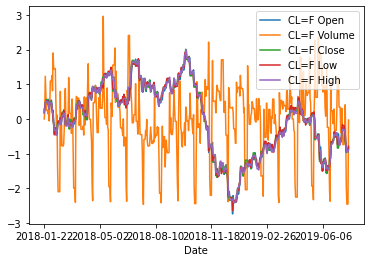

In [10]:
train_df.plot()

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [12]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[f'{instrument} Close'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[f'{instrument} Close'])
w1, w2

(Total window size: 48
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
 Label indices: [47]
 Label column name(s): ['CL=F Close'],
 Total window size: 7
 Input indices: [0 1 2 3 4 5]
 Label indices: [6]
 Label column name(s): ['CL=F Close'])

In [13]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


In [15]:
w2.example = example_inputs, example_labels

In [16]:
def plot(self, model=None, plot_col=f'{instrument} Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

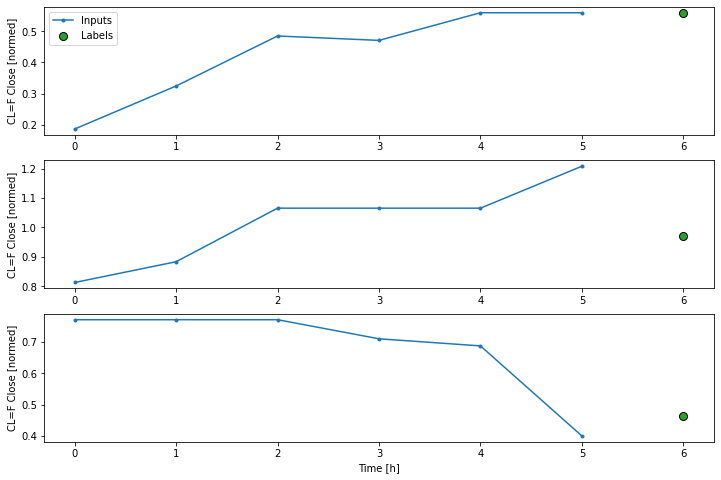

In [17]:
w2.plot()

In [18]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

## Single step prediction

In [246]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[f'{instrument} Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CL=F Close']

### Baseline model

In [247]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [248]:
baseline = Baseline(label_index=column_indices[f'{instrument} Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 0.1459 - mean_absolute_error: 0.1208


In [249]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[f'{instrument} Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['CL=F Close']

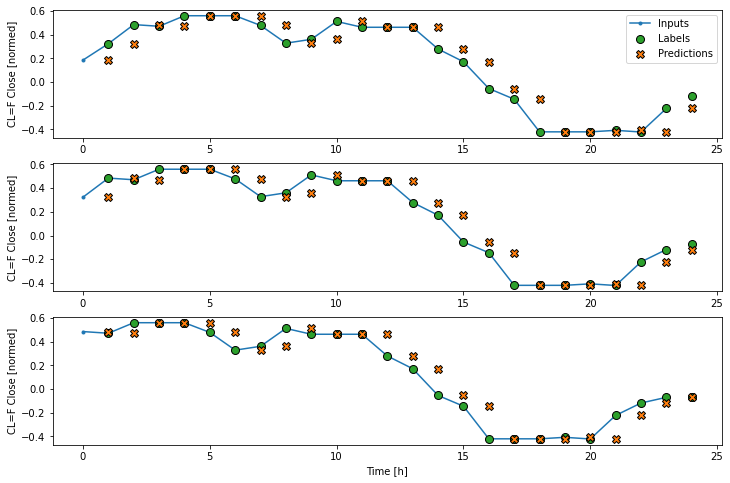

In [250]:
wide_window.plot(baseline)

### Linear model

In [251]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [253]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
18/18 [==============================] - 1s 18ms/step - loss: 0.7644 - mean_absolute_error: 0.7286 - val_loss: 6.9938 - val_mean_absolute_error: 1.9223
Epoch 2/50
18/18 [==============================] - 0s 9ms/step - loss: 0.6807 - mean_absolute_error: 0.6871 - val_loss: 6.2134 - val_mean_absolute_error: 1.8103
Epoch 3/50
18/18 [==============================] - 0s 9ms/step - loss: 0.6105 - mean_absolute_error: 0.6512 - val_loss: 5.5058 - val_mean_absolute_error: 1.7019
Epoch 4/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5470 - mean_absolute_error: 0.6168 - val_loss: 4.8673 - val_mean_absolute_error: 1.5974
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.4894 - mean_absolute_error: 0.5836 - val_loss: 4.2931 - val_mean_absolute_error: 1.4968
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.4373 - mean_absolute_error: 0.5517 - val_loss: 3.7785 - val_mean_absolute_error: 1.4002
Epoch 7/50
18/18 [========

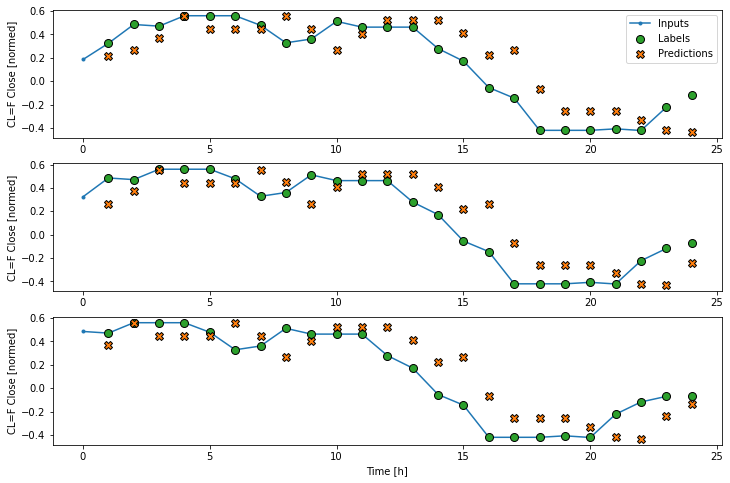

In [254]:
wide_window.plot(linear)

Plot weights

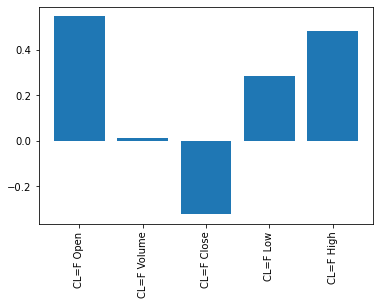

In [255]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense

In [256]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
18/18 [==============================] - 1s 20ms/step - loss: 0.3020 - mean_absolute_error: 0.4380 - val_loss: 1.3362 - val_mean_absolute_error: 0.7709
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.0547 - mean_absolute_error: 0.1850 - val_loss: 0.4602 - val_mean_absolute_error: 0.2625
Epoch 3/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0338 - mean_absolute_error: 0.1466 - val_loss: 0.4166 - val_mean_absolute_error: 0.2418
Epoch 4/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0228 - mean_absolute_error: 0.1156 - val_loss: 0.3567 - val_mean_absolute_error: 0.2492
Epoch 5/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0209 - mean_absolute_error: 0.1096 - val_loss: 0.3337 - val_mean_absolute_error: 0.2225
Epoch 6/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0204 - mean_absolute_error: 0.1088 - val_loss: 0.3126 - val_mean_absolute_error: 0.2107
Epoch 7/50
18/18 [=========

### Multi-step dense

In [257]:
CONV_WIDTH = 40
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[f'{instrument} Close'])

conv_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40]
Label column name(s): ['CL=F Close']

In [258]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [259]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.8506 - mean_absolute_error: 0.5367


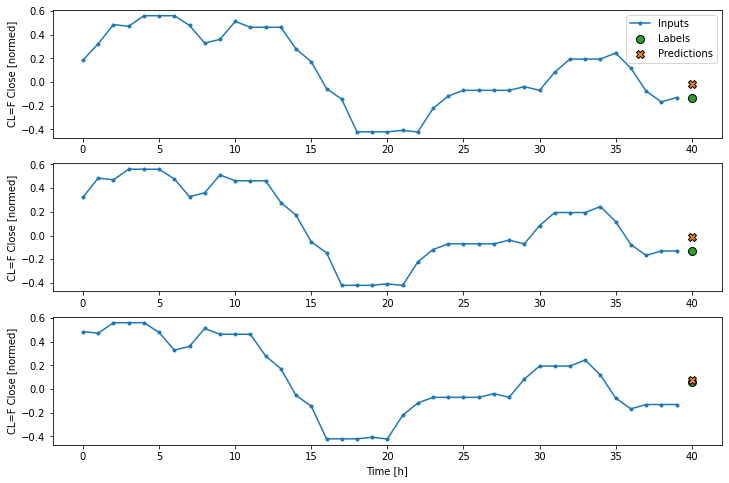

In [260]:
conv_window.plot(multi_step_dense)

### CNN

In [261]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [262]:
history = compile_and_fit(conv_model, conv_window, 10)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 0.6080 - mean_absolute_error: 0.4319


In [263]:
LABEL_WIDTH = 20
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[f'{instrument} Close'])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['CL=F Close']

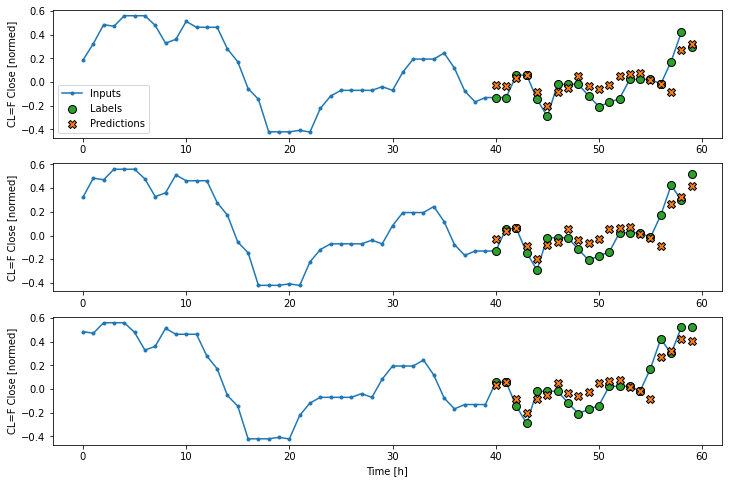

In [264]:
wide_conv_window.plot(conv_model)

### LSTM

In [265]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [266]:
history = compile_and_fit(lstm_model, wide_window, 1)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 0s 4ms/step - loss: 1.1858 - mean_absolute_error: 0.5525


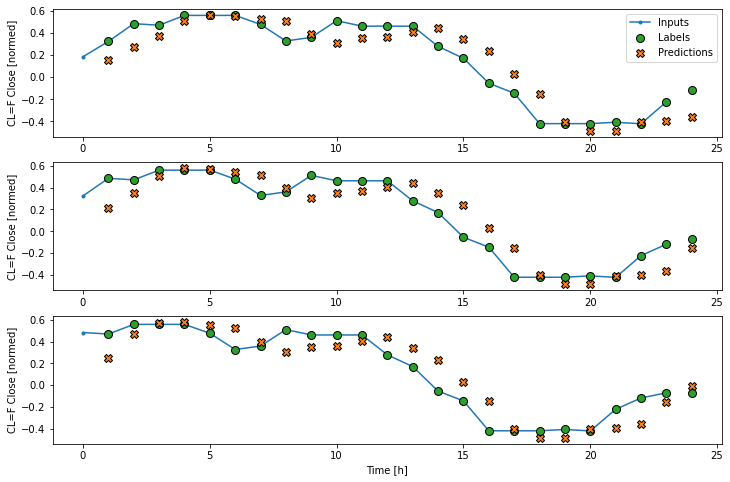

In [267]:
wide_window.plot(lstm_model)

## LSTM + CNN

In [268]:
combined_model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=64,
#                            kernel_size=(CONV_WIDTH,),
#                            activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1),
])

In [269]:
history = compile_and_fit(combined_model, wide_window)

val_performance['combined'] = combined_model.evaluate(wide_window.val)
performance['combined'] = combined_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
17/17 [==============================] - 5s 79ms/step - loss: 0.8355 - mean_absolute_error: 0.7176 - val_loss: 9.5218 - val_mean_absolute_error: 2.2264
Epoch 2/50
17/17 [==============================] - 0s 23ms/step - loss: 0.5922 - mean_absolute_error: 0.6070 - val_loss: 6.7417 - val_mean_absolute_error: 1.8110
Epoch 3/50
17/17 [==============================] - 0s 24ms/step - loss: 0.2064 - mean_absolute_error: 0.3340 - val_loss: 2.9172 - val_mean_absolute_error: 1.0533
Epoch 4/50
17/17 [==============================] - 0s 23ms/step - loss: 0.2054 - mean_absolute_error: 0.3807 - val_loss: 3.0991 - val_mean_absolute_error: 1.0436
Epoch 5/50
17/17 [==============================] - 0s 23ms/step - loss: 0.2636 - mean_absolute_error: 0.4171 - val_loss: 2.5853 - val_mean_absolute_error: 0.9422
Epoch 6/50
17/17 [==============================] - 0s 23ms/step - loss: 0.0931 - mean_absolute_error: 0.2393 - val_loss: 2.6270 - val_mean_absolute_error: 0.9432
Epoch 7/50
17/17 [====

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

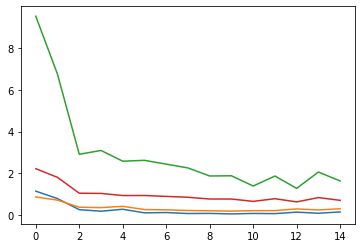

In [270]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_absolute_error'])
history.history.keys()

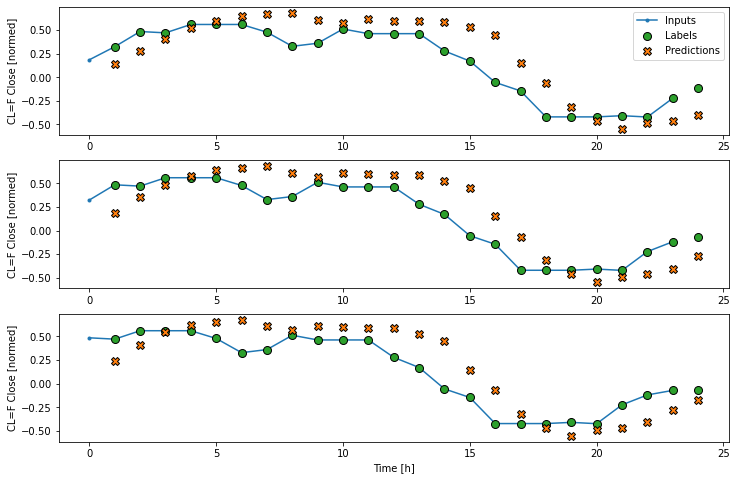

In [271]:
wide_window.plot(combined_model)

### Performance

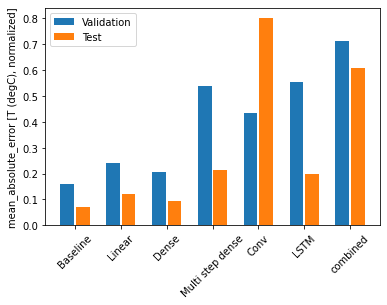

In [272]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [273]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0705
Linear      : 0.1210
Dense       : 0.0935
Multi step dense: 0.2153
Conv        : 0.7999
LSTM        : 0.1994
combined    : 0.6068


## Multi-step

In [274]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 24, 5)


### Baseline

In [275]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [276]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 0s 2ms/step - loss: 1.5062 - mean_absolute_error: 0.2327


### Dense

In [277]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [278]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 2.3543 - mean_absolute_error: 0.4019


### RNN

In [279]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

10/10 [==============================] - 0s 4ms/step - loss: 3.2561 - mean_absolute_error: 0.7753

Wall time: 25.4 s


### Res Nets

In [280]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [281]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

10/10 [==============================] - 0s 6ms/step - loss: 3.1946 - mean_absolute_error: 0.3603

Wall time: 7.67 s


### Performance

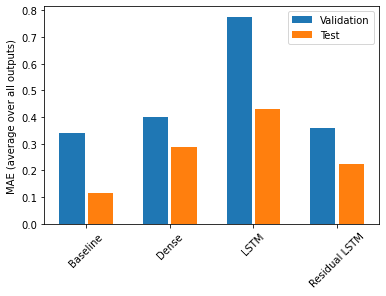

In [282]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [283]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1139
Dense          : 0.2868
LSTM           : 0.4292
Residual LSTM  : 0.2231


## Multi-step model

Total window size: 10
Input indices: [0 1 2 3 4]
Label indices: [5 6 7 8 9]
Label column name(s): None

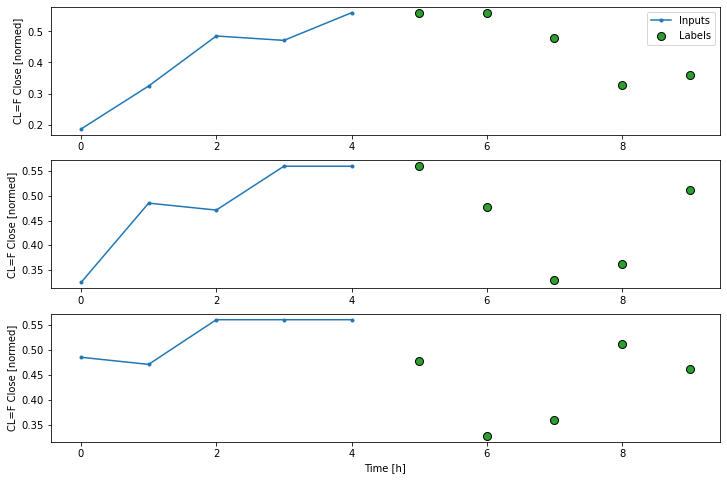

In [26]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=5,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

10/10 [==============================] - 0s 2ms/step - loss: 1.6734 - mean_absolute_error: 0.3718


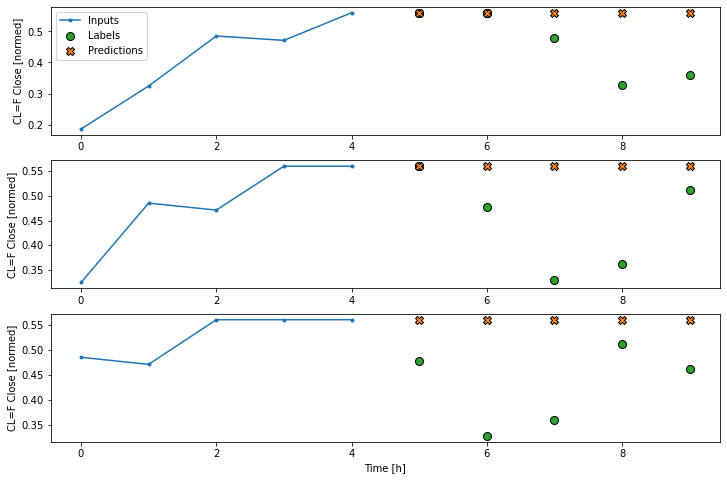

In [27]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

10/10 [==============================] - 0s 1ms/step - loss: 1.8090 - mean_absolute_error: 0.4615


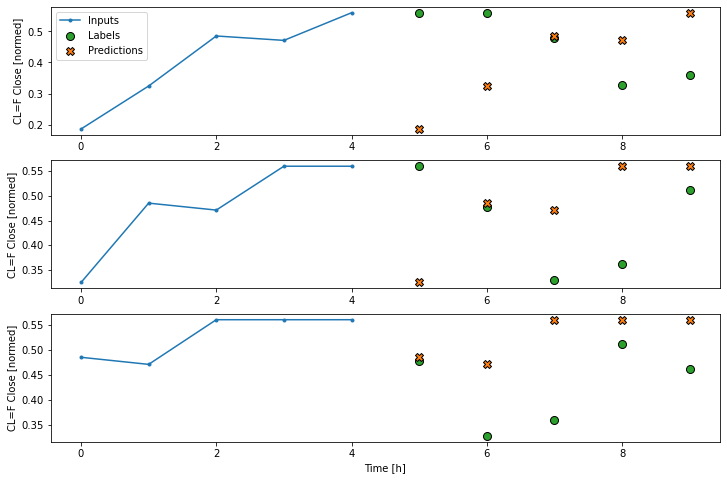

In [28]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models

10/10 [==============================] - 0s 2ms/step - loss: 2.2157 - mean_absolute_error: 0.4629


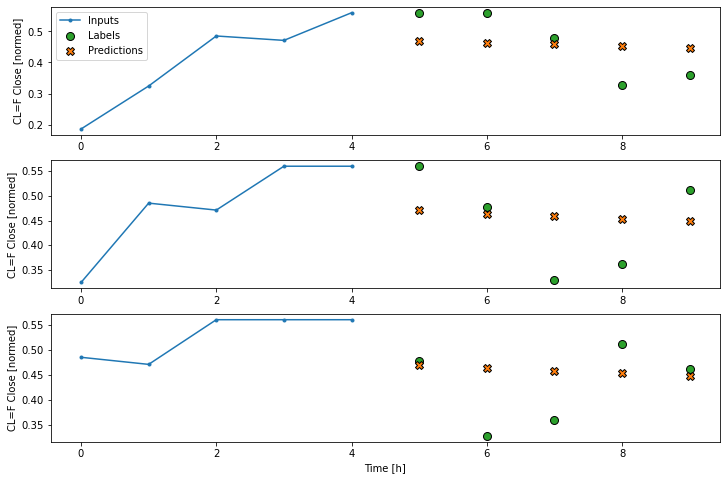

In [29]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

10/10 [==============================] - 0s 2ms/step - loss: 2.2719 - mean_absolute_error: 0.4835


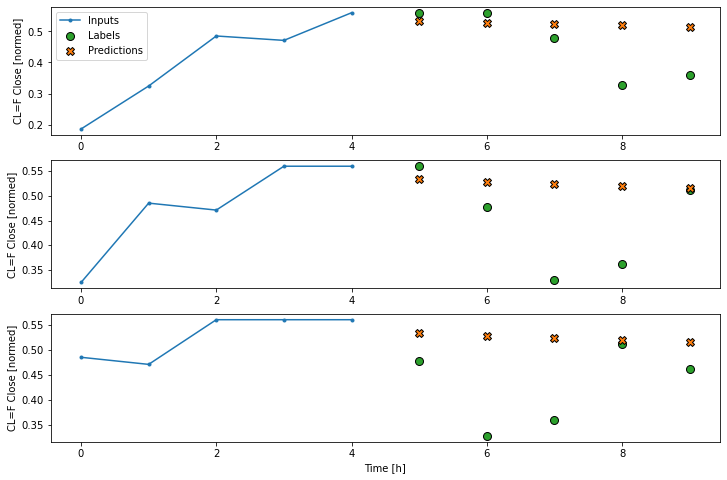

In [30]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

10/10 [==============================] - 0s 2ms/step - loss: 2.1748 - mean_absolute_error: 0.4707


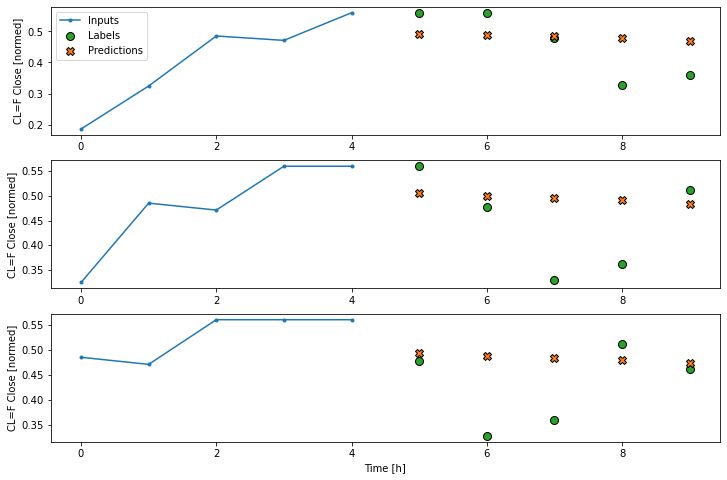

In [31]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

10/10 [==============================] - 0s 2ms/step - loss: 3.8540 - mean_absolute_error: 0.9530


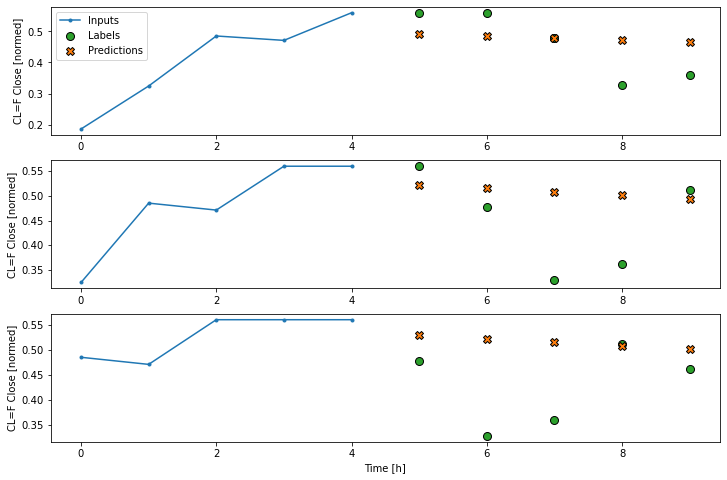

In [32]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Autoregressive models

### RNN

In [33]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [34]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [35]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [36]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [37]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [38]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 5, 5)


10/10 [==============================] - 0s 3ms/step - loss: 3.6228 - mean_absolute_error: 0.9272


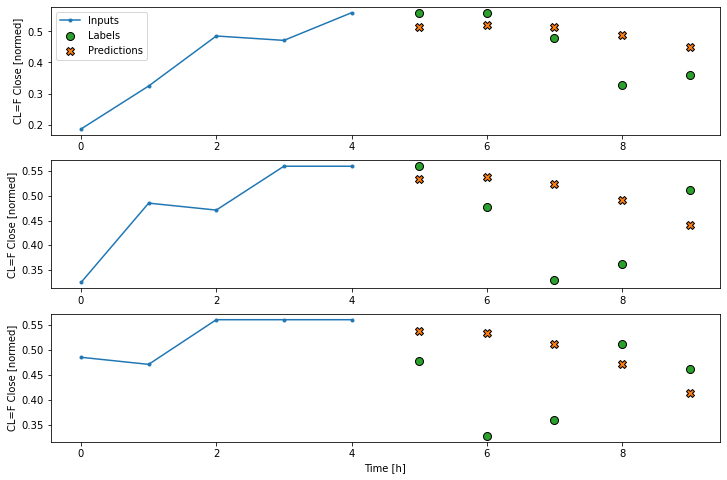

In [39]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

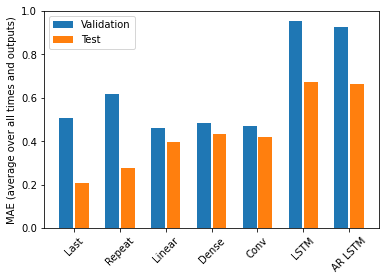

In [41]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [42]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2066
Repeat  : 0.2777
Linear  : 0.3965
Dense   : 0.4331
Conv    : 0.4210
LSTM    : 0.6722
AR LSTM : 0.6650
